In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

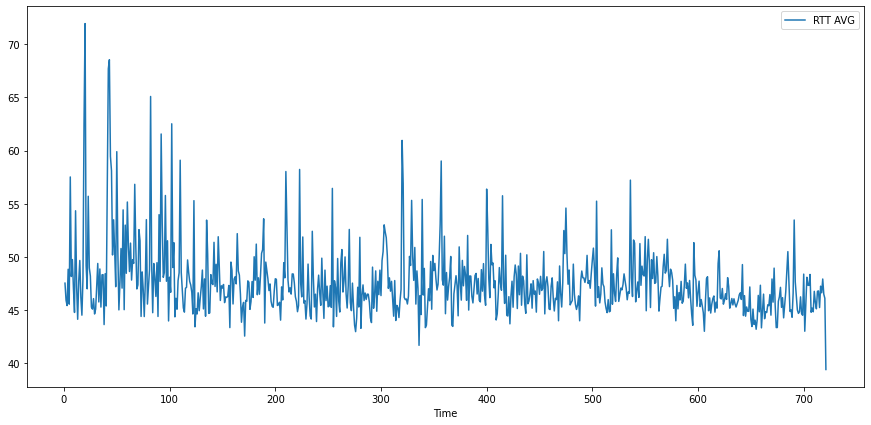

In [5]:
df=pd.read_csv('Latency.csv')
df.head()

df.head()
df.describe()
df.set_index('Time',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()


In [8]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['RTT AVG'])

In [17]:
def adfuller_test(RTT_AVG):
    result=adfuller(df['RTT AVG'])
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
result=adfuller(df['RTT AVG'])
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['RTT AVG'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -6.81495368283692
p-value : 2.070487195686914e-09
#Lags Used : 7
Number of Observations : 713


In [18]:
df['RTT First Difference'] = df['RTT AVG'] - df['RTT AVG'].shift(1)
df['Seasonal First Difference']=df['RTT AVG']-df['RTT AVG'].shift(12)
df.head()

,RTT AVG,RTT First Difference,Seasonal First Difference
Time,,,
1,47.527222,NaN,NaN
2,45.916417,-1.610806,NaN
3,45.418750,-0.497667,NaN
4,48.833167,3.414417,NaN
5,45.554500,-3.278667,NaN


In [19]:
# Again testing if data is stationary
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -6.81495368283692
p-value : 2.070487195686914e-09
#Lags Used : 7
Number of Observations : 713


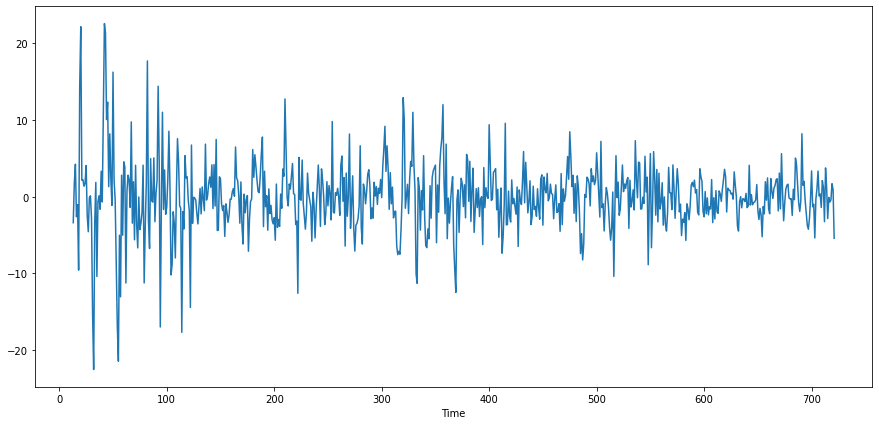

In [20]:
df['Seasonal First Difference'].plot()

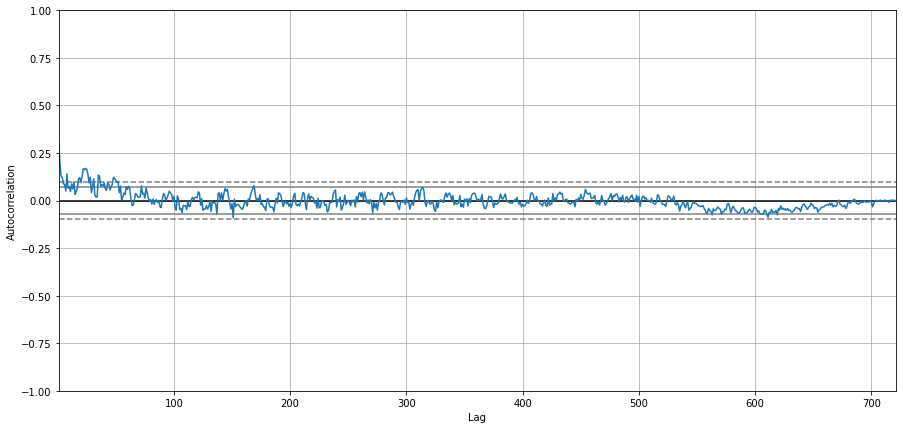

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['RTT AVG'])
plt.show()

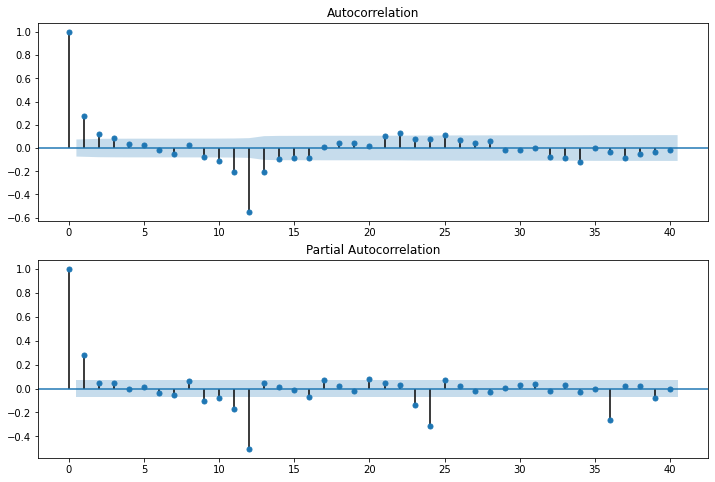

In [22]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [24]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['RTT AVG'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.RTT AVG   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1842.883
Method:                       css-mle   S.D. of innovations              3.123
Date:                Sun, 26 Jun 2022   AIC                           3693.765
Time:                        22:30:47   BIC                           3712.082
Sample:                             1   HQIC                          3700.836
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0056      0.003     -1.645      0.100      -0.012       0.001
ar.L1.D.RTT AVG     0.2252      0.038      5.932      0.000       0.151       0.300
ma.L1.D.RTT AVG    -0.9790      0.009   -106.101      0.000      -0.997      -0.961
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.4404           +0.0000j            4.4404            0.0000
MA.1            1.0214           +0.0000j            1.0214            0.0000
-----------------------------------------------------------------------------
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


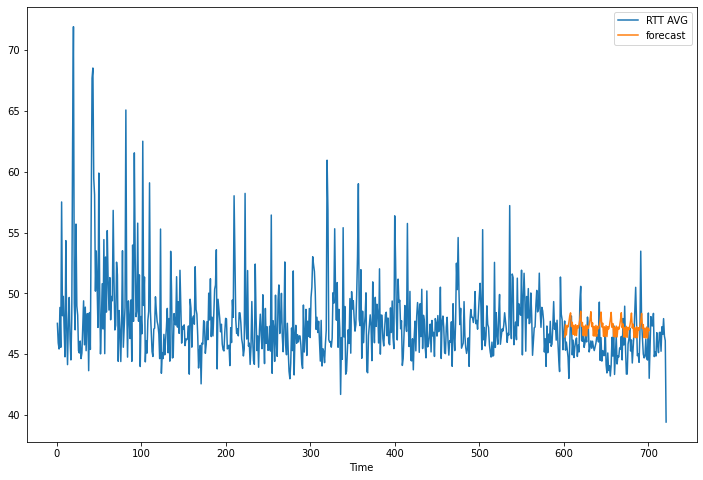

In [32]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['RTT AVG'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=600,end=700,dynamic=True)
df[['RTT AVG','forecast']].plot(figsize=(12,8))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


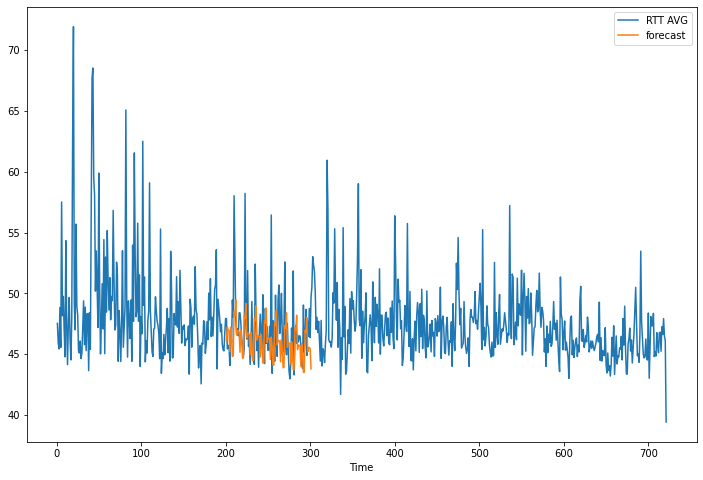

In [35]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['RTT AVG'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=200,end=300,dynamic=True)
df[['RTT AVG','forecast']].plot(figsize=(12,8))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


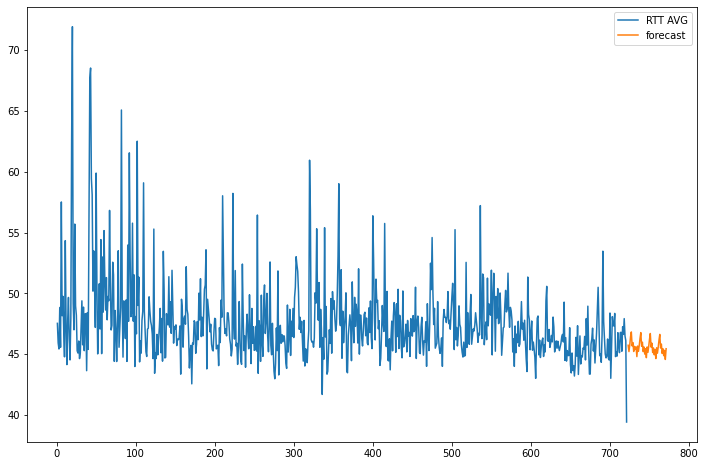

In [41]:
from pandas.tseries.offsets import DateOffset
future_dates=range(722,772)
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_df=pd.concat([df,future_datest_df])

future_df['forecast'] = results.predict(start = 722, end = 771, dynamic= True)
future_df[['RTT AVG', 'forecast']].plot(figsize=(12, 8))